In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [2]:
df = pd.read_csv('data_test')
df = df.drop(columns=df.columns[0])

In [3]:
df.head(5)

,X1,X2,Sin,pdiv,Y1,Y2
0,0.457633,0.274310,0.668316,0.348848,0,1
1,0.170258,0.905733,0.880061,0.536556,1,0
2,0.426743,0.067306,0.474195,0.196196,0,1
3,0.033611,0.259964,0.289376,0.079348,0,0
4,0.726409,0.747385,0.995299,0.684748,1,1


# 1. Modelo 1

In [4]:
df_t = torch.Tensor(df[['X1', 'X2']].values)
y1 = torch.Tensor(df[['Y1']].values)
y2 = torch.Tensor(df[['Y2']].values)

In [5]:
model1 = torch.nn.Sequential(
    torch.nn.Linear(2,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.Sigmoid()
)

criterion1 = torch.nn.MSELoss()

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.8)

In [6]:
epochs = 10**5
tau = 1
log_each = 1000
l = []
model1.train()

for e in range(1, epochs + 1):
    y_pred_0 = model1(df_t)
    y_pred_1 = 1 - model1(df_t)

    y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)

    y_pred = F.gumbel_softmax(y_pred.log(), tau=tau, hard=True)

    loss = criterion1(y_pred[:, 0].reshape(1000, 1), y1)
    l.append(loss.item())

    optimizer1.zero_grad()

    loss.backward()

    optimizer1.step()

    if not e % log_each:
        print(f'Epoch {e}/{epochs} Loss {np.mean(l):.5f}')
        lr = 0.8 - (0.6*e/epochs)
        optimizer1 = torch.optim.SGD(model1.parameters(), lr=lr)
        tau = 1 - (0.3*e/epochs)

Epoch 1000/100000 Loss 0.22320
Epoch 2000/100000 Loss 0.21537
Epoch 3000/100000 Loss 0.21255
Epoch 4000/100000 Loss 0.21112
Epoch 5000/100000 Loss 0.21036
Epoch 6000/100000 Loss 0.20968
Epoch 7000/100000 Loss 0.20922
Epoch 8000/100000 Loss 0.20881
Epoch 9000/100000 Loss 0.20849
Epoch 10000/100000 Loss 0.20818
Epoch 11000/100000 Loss 0.20792
Epoch 12000/100000 Loss 0.20767
Epoch 13000/100000 Loss 0.20745
Epoch 14000/100000 Loss 0.20729
Epoch 15000/100000 Loss 0.20712
Epoch 16000/100000 Loss 0.20695
Epoch 17000/100000 Loss 0.20678
Epoch 18000/100000 Loss 0.20657
Epoch 19000/100000 Loss 0.20643
Epoch 20000/100000 Loss 0.20628
Epoch 21000/100000 Loss 0.20616
Epoch 22000/100000 Loss 0.20603
Epoch 23000/100000 Loss 0.20590
Epoch 24000/100000 Loss 0.20579
Epoch 25000/100000 Loss 0.20568
Epoch 26000/100000 Loss 0.20556
Epoch 27000/100000 Loss 0.20545
Epoch 28000/100000 Loss 0.20534
Epoch 29000/100000 Loss 0.20522
Epoch 30000/100000 Loss 0.20513
Epoch 31000/100000 Loss 0.20504
Epoch 32000/10000

In [7]:
y_hat1 = model1(df_t).squeeze().detach().numpy()

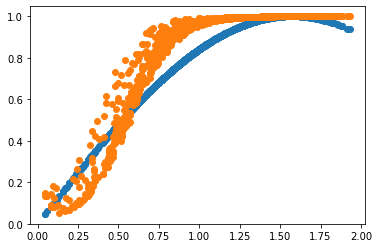

In [8]:
plt.scatter(df.X1.values + df.X2.values, df.Sin.values)
plt.scatter(df.X1.values + df.X2.values, y_hat1, cmap='red')

# 2. Modelo 2

In [9]:
model2 = torch.nn.Sequential(
    torch.nn.Linear(2,8),
    torch.nn.ReLU(),
    torch.nn.Linear(8,1),
    torch.nn.Sigmoid()
)

criterion2 = torch.nn.MSELoss()

optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.8)

In [10]:
N = 10**2
y_pred_0 = model2(df_t)
y_pred_1 = 1 - model2(df_t)

y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)
logits = y_pred.log()

y_pred = F.gumbel_softmax(logits, tau=tau, hard=True)

for i in range(1, N):
    x = i/N
    tau = 1 + x*(0.3-1)
    y_pred += F.gumbel_softmax(logits=logits, tau=tau, hard=True)

y_pred = y_pred/N

y_pred.detach().numpy()


array([[0.53, 0.47],
       [0.53, 0.47],
       [0.44, 0.56],
       ...,
       [0.57, 0.43],
       [0.55, 0.45],
       [0.5 , 0.5 ]], dtype=float32)

In [11]:
N = 10**2
epochs = 10**4
log_each = 10
l = []
model2.train()

for e in range(1, epochs + 1):

    tau = 1

    y_pred_0 = model2(df_t)
    y_pred_1 = 1 - model2(df_t)

    y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)
    logits = y_pred.log()

    y_pred = F.gumbel_softmax(logits, tau=tau, hard=True)

    for i in range(1, N):
        x = i/N
        tau = 1 + x*(0.3-1)
        y_pred += F.gumbel_softmax(logits=logits, tau=tau, hard=True)

    y_pred = y_pred/N

    loss = criterion2(y_pred[:, 0].reshape(1000, 1), y1)
    l.append(loss.item())

    optimizer2.zero_grad()

    loss.backward()

    optimizer2.step()

    if not e % log_each:
        print(f'Epoch {e}/{epochs} Loss {np.mean(l):.5f}')
        lr = 0.8 - (0.6*e/epochs)
        optimizer2 = torch.optim.SGD(model2.parameters(), lr=lr)

Epoch 10/10000 Loss 0.19130
Epoch 20/10000 Loss 0.17391
Epoch 30/10000 Loss 0.16684
Epoch 40/10000 Loss 0.16284
Epoch 50/10000 Loss 0.16008
Epoch 60/10000 Loss 0.15783
Epoch 70/10000 Loss 0.15584
Epoch 80/10000 Loss 0.15403
Epoch 90/10000 Loss 0.15239
Epoch 100/10000 Loss 0.15090
Epoch 110/10000 Loss 0.14944
Epoch 120/10000 Loss 0.14811
Epoch 130/10000 Loss 0.14683
Epoch 140/10000 Loss 0.14559
Epoch 150/10000 Loss 0.14444
Epoch 160/10000 Loss 0.14334
Epoch 170/10000 Loss 0.14231
Epoch 180/10000 Loss 0.14135
Epoch 190/10000 Loss 0.14047
Epoch 200/10000 Loss 0.13963
Epoch 210/10000 Loss 0.13885
Epoch 220/10000 Loss 0.13814
Epoch 230/10000 Loss 0.13743
Epoch 240/10000 Loss 0.13680
Epoch 250/10000 Loss 0.13620
Epoch 260/10000 Loss 0.13565
Epoch 270/10000 Loss 0.13512
Epoch 280/10000 Loss 0.13461
Epoch 290/10000 Loss 0.13415
Epoch 300/10000 Loss 0.13370
Epoch 310/10000 Loss 0.13328
Epoch 320/10000 Loss 0.13288
Epoch 330/10000 Loss 0.13251
Epoch 340/10000 Loss 0.13217
Epoch 350/10000 Loss 0.

In [12]:
y_hat2 = model2(df_t).squeeze().detach().numpy()

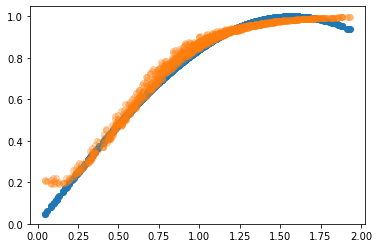

In [15]:
plt.scatter(df.X1.values + df.X2.values, df.Sin.values)
plt.scatter(df.X1.values + df.X2.values, y_hat2, cmap='red', alpha=0.3)

## Gráficas 3D


In [16]:
X, Y = np.meshgrid(np.linspace(-5,5,100), np.linspace(-5,5,100))
Z = np.sin(X + Y)

Locator attempting to generate 1001 ticks ([-1.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


Text(0.5, 0, 'Z')

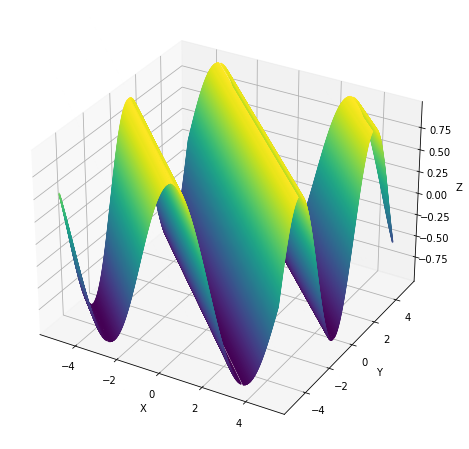

In [17]:
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 1000, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#fig.savefig('fun_C.eps')

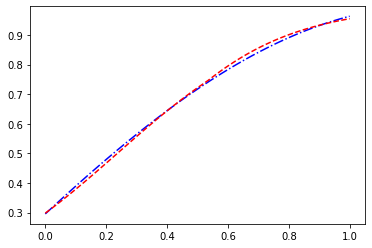

In [35]:
df_aux = pd.DataFrame(columns=['X1', 'X2'])

df_aux['X1'] = np.linspace(0, 1, 100)
df_aux['X2'] = np.full(fill_value=0.3, shape=100, dtype='float64')

plt.plot(df_aux.X1.values, np.sin(df_aux.X1.values + df_aux.X2.values), 'b-.')
plt.plot(df_aux.X1.values, model2(torch.Tensor(df_aux.values)).squeeze().detach().numpy(), 'r--')

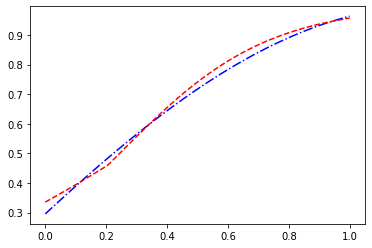

In [34]:
df_aux = pd.DataFrame(columns=['X1', 'X2'])

df_aux['X1'] = np.full(fill_value=0.3, shape=100, dtype='float64')
df_aux['X2'] = np.linspace(0, 1, 100)

plt.plot(df_aux.X2.values, np.sin(df_aux.X1.values + df_aux.X2.values), 'b-.')
plt.plot(df_aux.X2.values, model2(torch.Tensor(df_aux.values)).squeeze().detach().numpy(), 'r--')